In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [3]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/SVHN', 'Copy of SVHN_result.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/SVHN'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/SVHN/Copy of SVHN_result.csv


In [4]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [5]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"conv1x1FLOPS": 0.049152, "conv1x1_3x3FLOPS": 1.204, "conv1x1_5x5FLOPS": 3.301, "totalFLOPS": 17.927}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [6]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [7]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch0', 'train accuracy epoch1', 'train accuracy epoch2', 'test accuracy epoch0', 'test accuracy epoch1', 'test accuracy epoch2']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    std_norm = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = std_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [8]:
combined_avg_norm_var_acc_integrated_gradients.to_csv(save_folder+"/SVHN ig.csv")
combined_avg_norm_var_acc_integrated_gradients=pd.read_csv(save_folder+"/SVHN ig.csv")

In [9]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_2_accuracy_cols = ['test accuracy epoch2']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_integrated_gradients

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,norm_var_norm_conv1x1,...,train accuracy epoch1,train accuracy epoch2,test accuracy epoch0,test accuracy epoch1,test accuracy epoch2,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.009012,0.050717,0.940270,2.233388,...,76.873564,79.954680,71.404938,76.024892,77.500768,0.049152,1.204,3.301,17.927,77.500768
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.043836,0.051646,0.904519,0.240312,...,77.269521,80.655318,71.409291,76.556546,78.295687,0.049152,1.204,3.301,17.927,78.295687
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.085345,0.055427,0.859229,0.289848,...,75.906011,80.041862,68.792768,75.469422,77.725620,0.049152,1.204,3.301,17.927,77.725620
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.007492,0.040979,0.951530,3.069204,...,77.043104,80.121308,71.631838,75.711432,77.487451,0.049152,1.204,3.301,17.927,77.487451
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.044809,0.047796,0.907395,0.459397,...,77.218832,80.597167,71.368572,76.283292,78.032678,0.049152,1.204,3.301,17.927,78.032678
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.079955,0.054994,0.865051,0.325930,...,76.234444,80.217681,69.715222,75.860992,77.877228,0.049152,1.204,3.301,17.927,77.877228
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.035172,0.064493,0.900335,0.960954,...,69.430453,74.265576,61.955542,69.490883,72.471317,0.049152,1.204,3.301,17.927,72.471317
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.041418,0.070245,0.888338,0.429595,...,72.737622,77.052750,65.855358,72.646486,74.785648,0.049152,1.204,3.301,17.927,74.785648
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.101813,0.093386,0.804801,0.321310,...,70.020157,76.097392,61.655655,70.655603,74.313921,0.049152,1.204,3.301,17.927,74.313921
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.030868,0.068426,0.900706,1.467285,...,70.598942,74.755359,63.329492,69.593577,72.394745,0.049152,1.204,3.301,17.927,72.394745


# Graph

In [10]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [11]:
filtered_integrated_gradients.to_csv(save_folder+"/SVHN ig ave var.csv")

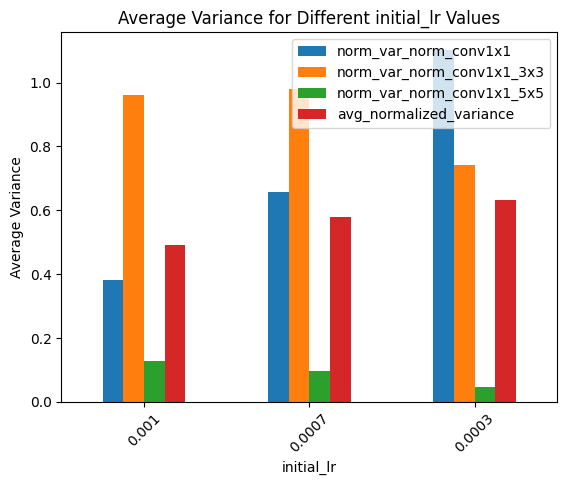

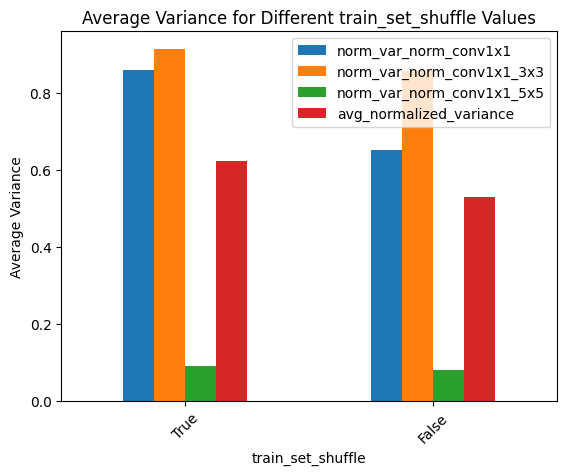

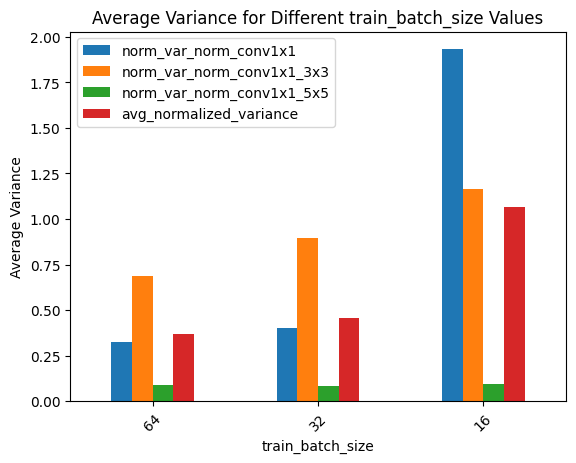

In [12]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}

for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_integrated_gradients, hyperparam, variables)

# T test

In [13]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [14]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.5648949751995854 P-value: 0.587631369446188


In [15]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.2383783281330665 P-value: 0.8164013901528855


In [16]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.5978792537263853 P-value: 0.5664564316641539


train_set_shuffle

In [17]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.5689580345740981 P-value: 0.5783986495102205


train_batch_size

In [18]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.166662030254056 P-value: 0.055481888572010835


In [19]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -6.97223983349622 P-value: 0.00011580796497941319


In [20]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -5.676219312774147 P-value: 0.0004670283614858981


# Paired T test

In [21]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [22]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [23]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [24]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [25]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.4320649838461665 0.3513948565812155
0.5237415763332262 0.4791771648394358
0.4226619822455268 0.3494397065214991
0.5839376469055495 0.4339473077932005
T-statistic: 3.896275530300263 One-sided P-value: 0.014997702077896718


In [26]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.3513948565812155 0.3513964830380789
0.4791771648394358 0.3929481987390232
1.1011471524402914 1.345457055079862
0.3494397065214991 0.2938911621971673
0.4339473077932005 0.3367102886042998
0.7504934523102963 1.0616427069478451
T-statistic: -0.7226663050469335 One-sided P-value: 0.7488689172459764


In [27]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.4320649838461665 0.3513964830380789
0.5237415763332262 0.3929481987390232
0.4226619822455268 0.2938911621971673
0.5839376469055495 0.3367102886042998
T-statistic: 4.148404279342947 One-sided P-value: 0.012725238023131396


train_set_shuffle

In [28]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.4320649838461665 0.4226619822455268
0.5237415763332262 0.5839376469055495
0.3513948565812155 0.3494397065214991
0.4791771648394358 0.4339473077932005
1.1011471524402914 0.7504934523102963
0.3513964830380789 0.2938911621971673
0.3929481987390232 0.3367102886042998
1.345457055079862 1.0616427069478451
T-statistic: 1.8201441955196218 One-sided P-value: 0.055772488818234926


train_batch_size

In [29]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.5237415763332262 0.4320649838461665
0.5839376469055495 0.4226619822455268
0.4791771648394358 0.3513948565812155
0.4339473077932005 0.3494397065214991
0.3929481987390232 0.3513964830380789
0.3367102886042998 0.2938911621971673
T-statistic: 4.762476735928378 One-sided P-value: 0.0025241681052993034


In [30]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

1.1011471524402914 0.4791771648394358
0.7504934523102963 0.4339473077932005
1.345457055079862 0.3929481987390232
1.0616427069478451 0.3367102886042998
T-statistic: 4.955033920286332 One-sided P-value: 0.007889033991747051


In [31]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

1.1011471524402914 0.3513948565812155
0.7504934523102963 0.3494397065214991
1.345457055079862 0.3513964830380789
1.0616427069478451 0.2938911621971673
T-statistic: 5.9497326848665 One-sided P-value: 0.004747394777906556


#layer feature attribution rank frequency comparison

In [32]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'integrated_gradients']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-9-80b24c92b05c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,train accuracy epoch1,train accuracy epoch2,test accuracy epoch0,...,method,run,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,final_test_accuracy
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,57.822461,75.282908,78.463492,69.948525,...,integrated_gradients,0,0.049152,1.204,3.301,17.927,0.061474,0.056091,0.882435,76.167793
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,49.644403,69.294402,73.767695,63.414259,...,integrated_gradients,1,0.049152,1.204,3.301,17.927,0.130595,0.218823,0.650583,71.523510
5,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,25.653521,52.875493,70.901074,32.171942,...,integrated_gradients,2,0.049152,1.204,3.301,17.927,0.122817,0.173274,0.703909,71.692532
7,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,50.649085,69.131960,75.089070,62.219576,...,integrated_gradients,3,0.049152,1.204,3.301,17.927,0.154143,0.069151,0.776707,74.431469
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,46.585309,69.683443,75.400303,61.543485,...,integrated_gradients,4,0.049152,1.204,3.301,17.927,0.115487,0.215146,0.669367,74.719576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,61.939473,77.821915,80.620282,71.561924,...,integrated_gradients,10,0.049152,1.204,3.301,17.927,0.018238,0.064851,0.916911,78.084665
533,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,59.662558,77.185798,80.183464,72.284112,...,integrated_gradients,11,0.049152,1.204,3.301,17.927,0.020540,0.163581,0.815879,78.730025
535,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,61.639161,77.243130,80.306319,71.511985,...,integrated_gradients,12,0.049152,1.204,3.301,17.927,0.021012,0.029068,0.949920,78.015519
537,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,59.711700,76.761265,79.679758,71.135526,...,integrated_gradients,13,0.049152,1.204,3.301,17.927,-0.049169,-0.001759,1.050928,77.085894


In [33]:
# Select the columns of interest
cols_of_interest = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-33-2b13f1656abd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


123    121
213    114
132      1
Name: rank_combination, dtype: int64